In [1]:
from bitarray import bitarray
import random
import numpy as np
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [5]:
data =  pd.read_csv('magic04.data', sep=",")

In [6]:
data.head()

0         1       2       3       4         5        6        7  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110  -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238  -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580 -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633  -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525  21.8393   

         8         9 10  
0  40.0920   81.8828  g  
1   6.3609  205.2610  g  
2  76.9600  256.7880  g  
3  10.4490  116.7370  g  
4   4.6480  356.4620  g

In [7]:
X = np.array(data.values[:,:-1])
X[0:5]

array([[28.7967, 16.0021, 2.6449, 0.3918, 0.1982, 27.7004, 22.011,
        -8.2027, 40.092, 81.8828],
       [31.6036, 11.7235, 2.5185, 0.5303, 0.3773, 26.2722, 23.8238,
        -9.9574, 6.3609, 205.261],
       [162.05200000000002, 136.031, 4.0612, 0.0374, 0.0187, 116.741,
        -64.858, -45.216, 76.96, 256.788],
       [23.8172, 9.5728, 2.3385, 0.6147, 0.3922, 27.2107, -6.4633,
        -7.1513, 10.449000000000002, 116.73700000000001],
       [75.1362, 30.9205, 3.1611, 0.3168, 0.1832, -5.5277, 28.5525,
        21.8393, 4.648, 356.462]], dtype=object)

In [8]:
X = StandardScaler().fit_transform(X)
y = np.array(data.values[:,-1])
y[y=='g']=0
y[y=='h']=1


In [9]:
X = np.array(X)
y = np.array(y)
print(y)
print(X)

[0 0 0 ... 1 1 1]
[[-0.57722602 -0.33680419 -0.38113037 ... -0.40584194  0.47681587
  -1.49786555]
 [-0.51096889 -0.57002666 -0.64859479 ... -0.49009359 -0.81541816
   0.15312459]
 [ 2.56827756  6.20585836  2.61578306 ... -2.18302986  1.88922413
   0.84263513]
 ...
 [ 0.52392318  1.38177927  1.31887687 ... -0.4665087   0.10163583
   0.83900338]
 [ 1.58775746  2.98278123  2.47337518 ... -3.07720555  2.18525981
   2.87032093]
 [ 3.16145936  1.67999288  0.81314905 ...  1.49930076  0.96101431
   1.05044239]]


In [10]:
print(sum(y[0:12332]))
x_neg = X[:12332]
np.random.shuffle(x_neg)

0


In [11]:
x_test=x_neg[0:6166]
x_neg_train = x_neg[6166:]
x_pos_train = X[12332:]
x_train = np.concatenate((x_neg_train,x_pos_train))
np.random.shuffle(x_test)
y_train=y[6166:19020].reshape(-1,1).astype(int)
y_test=y[0:6166].reshape(-1,1).astype(float)

In [12]:
fpr_values_kraska = []
size_values_kraska = []

# Kraska Hash Model

In [13]:
class Kraska_Hash_BloomFilter:
    
    def __init__(self, size, model): #hash count is 1
        self.size = size
      #  self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        self.model=model #classifier model associated as hash function
        
    def add(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(model.predict(num)[0]*(self.size-1))    
        self.bit_array[result] = 1
            
    def lookup(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(self.model.predict(num)[0]*(self.size-1))    
        if self.bit_array[result] == 0:
                return False
        return True

    def add_init(self,x_train,y_train):
        pred = self.model.predict(x_train)
        for i in range(len(pred)):
            if(y_train[i]==1):
                result = math.floor(pred[i][0]*(self.size-1))
                self.bit_array[result] = 1

    def predict(self,x):
        initpred = self.model.predict(x)
        indexes = []
        for i in range(len(initpred)):
            indexes += [math.floor(initpred[i][0]*(self.size-1))]
        pred = []
        for i in indexes:
            pred += [self.bit_array[i]]
        return np.array(pred)

#adds ratio r of an array of random integers of size n to bloom filter bf(input : bf,size,ratio; output: data array)
def addrandom(bf,n,r):
    data=np.empty(n,dtype=int)
    for i in range(0,n):
        data[i]=random.randint(0, 100000000)
    for j in range(0,int(n*r)):
        bf.add(data[j])
    return data

#(Input:bloom filter,number array,ratio of positives; Output:(-1) for false negative, otherwise fpr)
def fpr_kraska_hash(bf,x_test,y_test):
    pred = bf.predict(x_test)
    tn, fp, fn, tp = confusion_matrix(y_test,pred,labels=[False,True]).ravel() 
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

#(Input:size of bloom filter, number of hash functions, total numbers, ratio of numbers inserted; Output: fpr)
def find_fpr(m,model,n,r):
    bf=Kraska_Hash_BloomFilter(model,m)
    data=addrandom(bf,n,r)
    return fpr(bf,data,r)

#(Input:size of bloom filter, total numbers, ratio of numbers inserted; Output: prints inputs and fpr)
def outputs(m,n,r):
    find_fpr(m,model,n,r)
    #print("For m=%d, k=%d, n=%d, r=%.3f: fpr=%.3f"%(m,k,n,r,find_fpr(m,k,n,r)))

In [14]:
def get_data_points_Kraska(x_train,y_train,x_test,y_test,init_size,diff,num,epochs,fpr_values_kraska,size_values_kraska):
    batch_size = len(x_train)
    input_dim = x_train.shape[1]
    additional_metrics = ['acc']
    loss_function = BinaryCrossentropy()
    optimizer = Adam()
    verbosity_mode = 0
    for i in range(0,num):
        layer_size = init_size + (diff*i)
        number_of_epochs = epochs
        model = Sequential()
        model.add(Dense(layer_size,input_dim=input_dim,activation='relu'))
        model.add(Dense(1,activation='sigmoid'))
        model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
        history = model.fit(x_train, y_train, batch_size = batch_size, epochs=number_of_epochs, verbose=verbosity_mode)

        print("Number of nodes: %d" %(init_size + (diff*i)))
        plt.plot(history.history['acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.show()
        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()

        model_size = ((input_dim+1)*layer_size + (layer_size+1))*32

        m = int(model_size/10) + 1
        net_size = model_size + m

        bf=Kraska_Hash_BloomFilter(m,model)
        bf.add_init(x_train,y_train)
        fpr = fpr_kraska_hash(bf,x_test,y_test)

        print("Size: %f bits - FPR: %f \n\n\n" % (net_size,fpr))
        fpr_values_kraska += [fpr]
        size_values_kraska += [net_size]

~~~~~~~~ Iteration 1 ~~~~~~~~ 

Number of nodes: 5


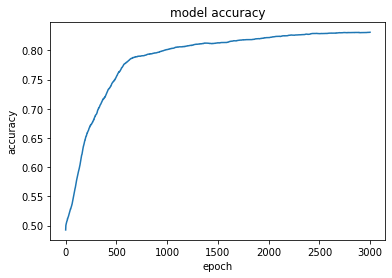

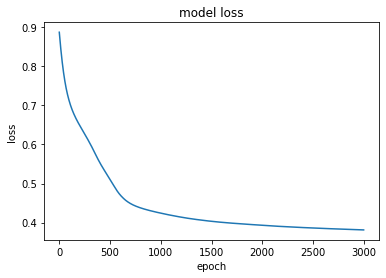

Size: 2148.000000 bits - FPR: 0.982322 



Number of nodes: 10


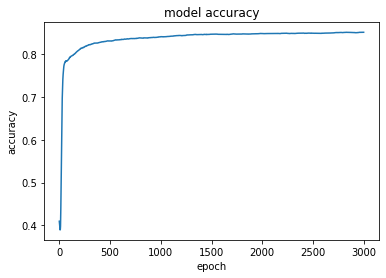

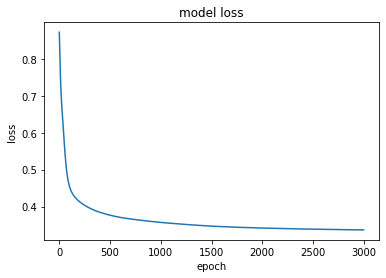

Size: 4260.000000 bits - FPR: 0.920694 



Number of nodes: 15


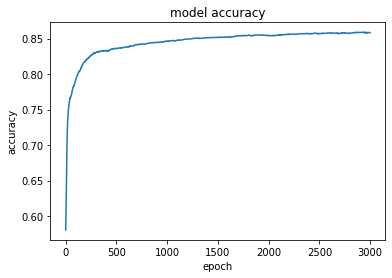

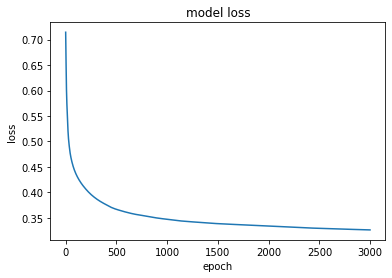

Size: 6372.000000 bits - FPR: 0.874797 



Number of nodes: 20


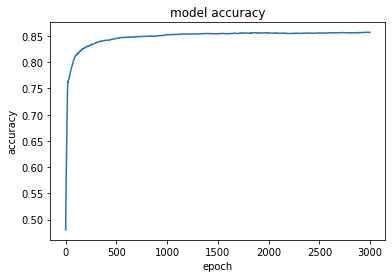

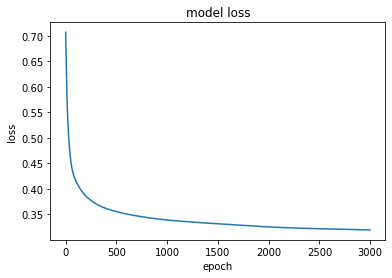

Size: 8484.000000 bits - FPR: 0.769543 



Number of nodes: 25


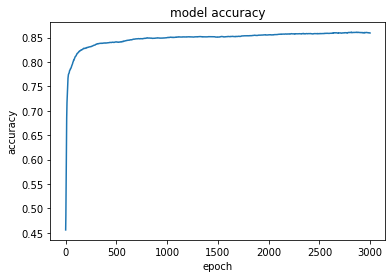

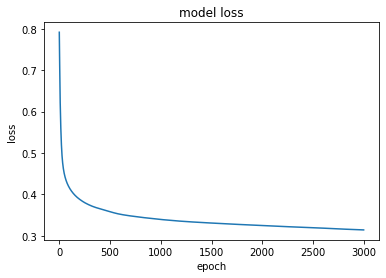

Size: 10596.000000 bits - FPR: 0.766623 



Number of nodes: 30


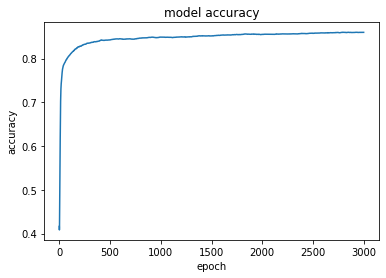

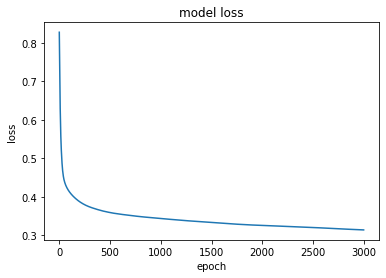

Size: 12708.000000 bits - FPR: 0.711158 



Number of nodes: 35


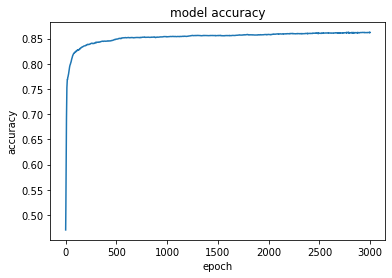

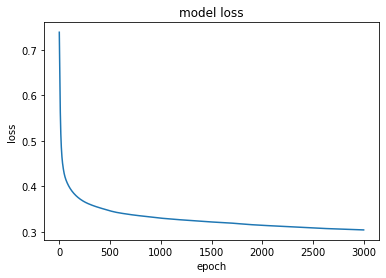

Size: 14820.000000 bits - FPR: 0.631041 



Number of nodes: 40


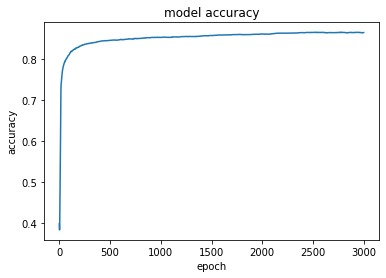

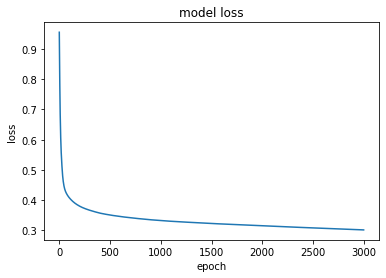

Size: 16932.000000 bits - FPR: 0.603308 



Number of nodes: 45


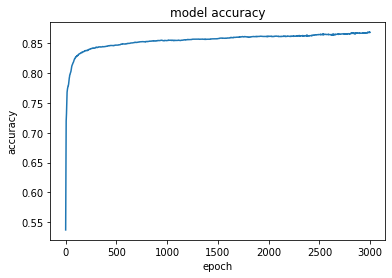

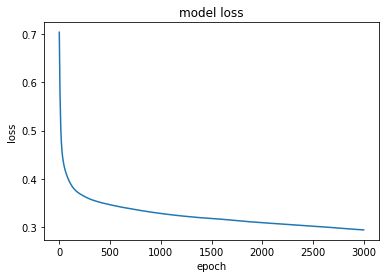

Size: 19044.000000 bits - FPR: 0.550276 



Number of nodes: 50


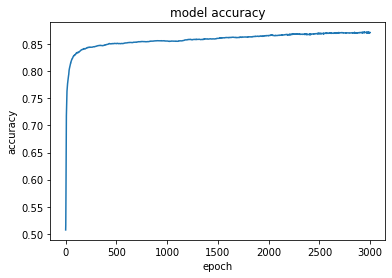

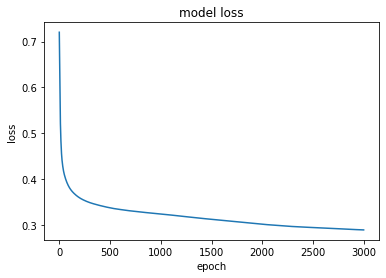

Size: 21156.000000 bits - FPR: 0.509406 



Number of nodes: 55


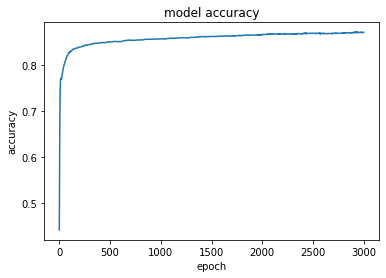

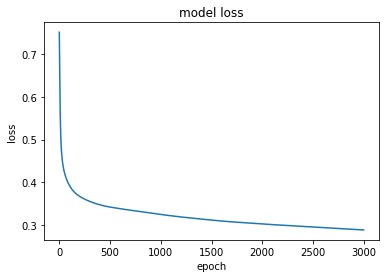

Size: 23268.000000 bits - FPR: 0.482647 



Number of nodes: 60


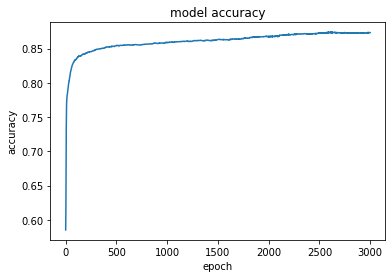

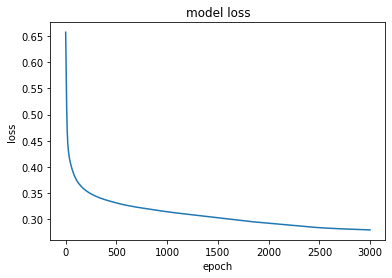

Size: 25380.000000 bits - FPR: 0.442913 



Number of nodes: 65


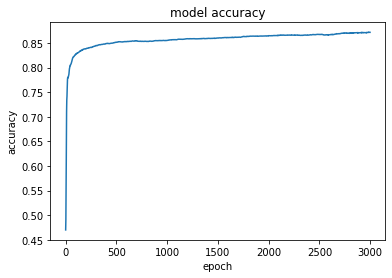

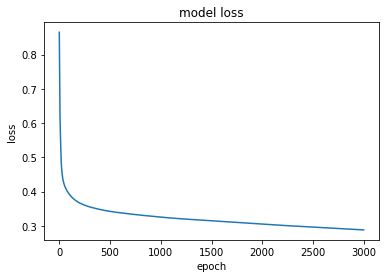

Size: 27492.000000 bits - FPR: 0.425560 



Number of nodes: 70


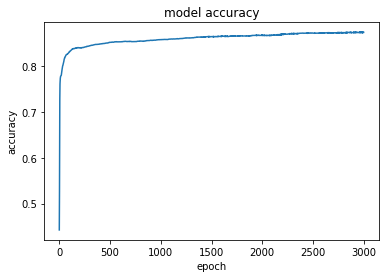

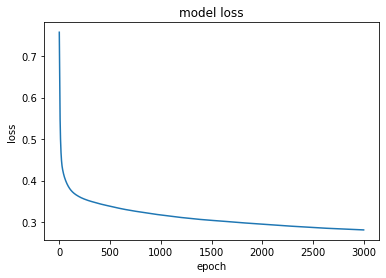

Size: 29604.000000 bits - FPR: 0.413558 



Number of nodes: 75


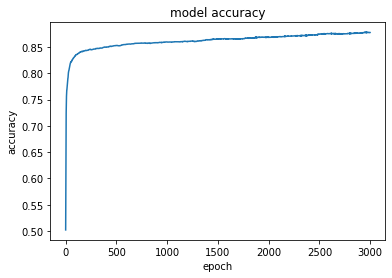

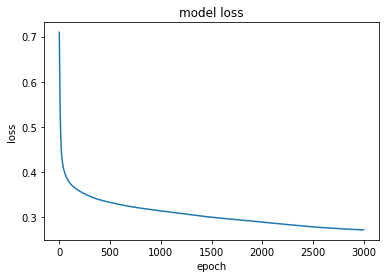

Size: 31716.000000 bits - FPR: 0.380474 



~~~~~~~~ Iteration 2 ~~~~~~~~ 

Number of nodes: 5


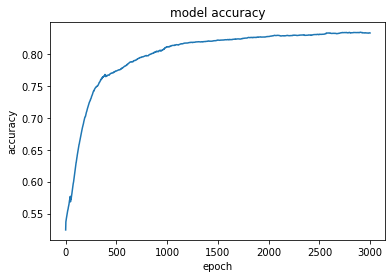

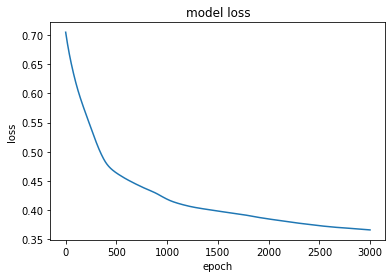

Size: 2148.000000 bits - FPR: 0.969186 



Number of nodes: 10


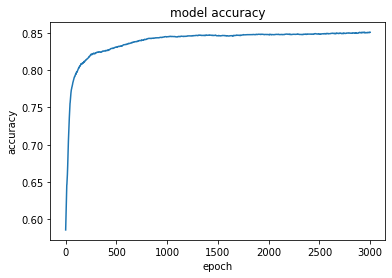

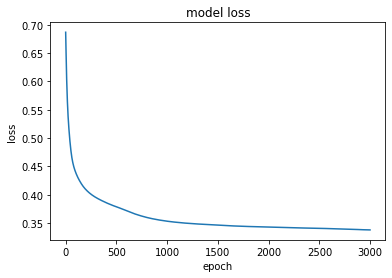

Size: 4260.000000 bits - FPR: 0.916315 



Number of nodes: 15


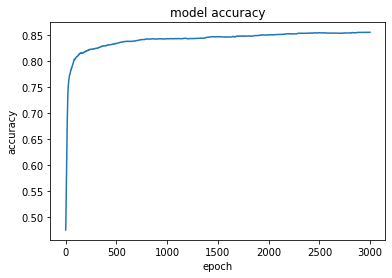

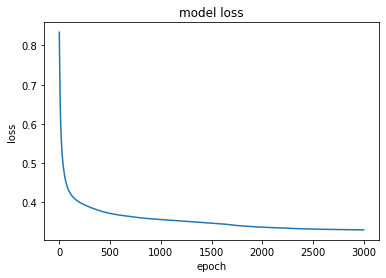

Size: 6372.000000 bits - FPR: 0.881609 



Number of nodes: 20


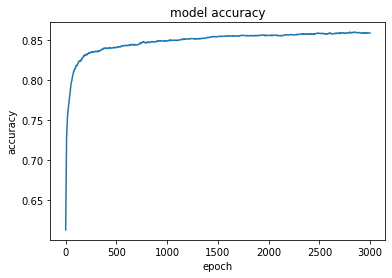

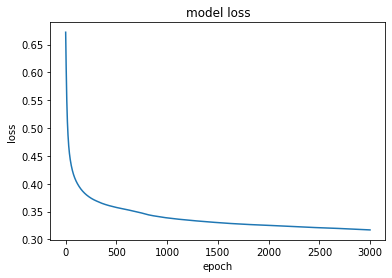

Size: 8484.000000 bits - FPR: 0.807006 



Number of nodes: 25


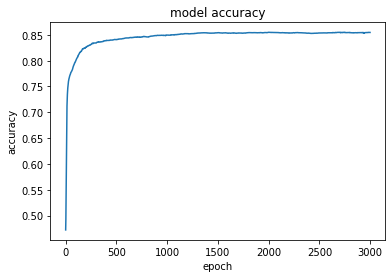

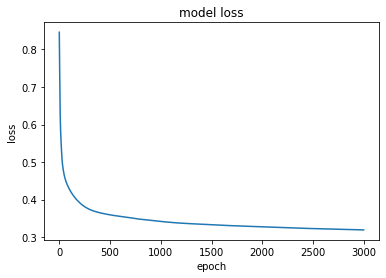

Size: 10596.000000 bits - FPR: 0.768570 



Number of nodes: 30


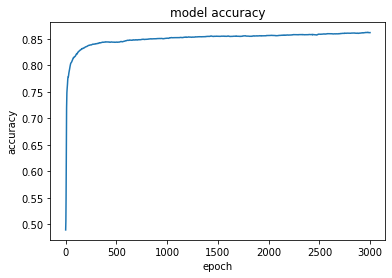

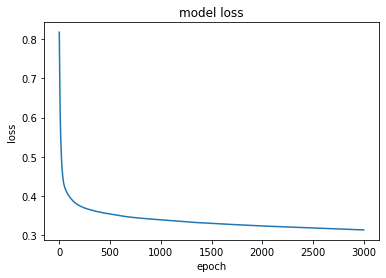

Size: 12708.000000 bits - FPR: 0.707914 



Number of nodes: 35


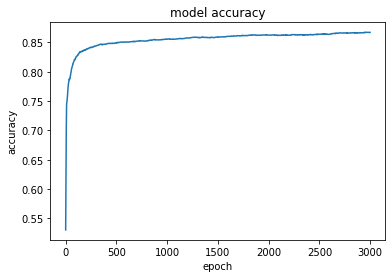

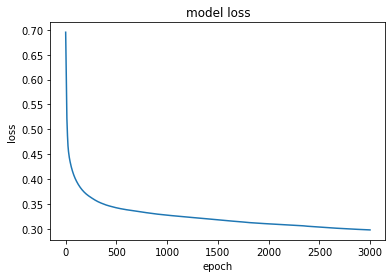

Size: 14820.000000 bits - FPR: 0.636555 



Number of nodes: 40


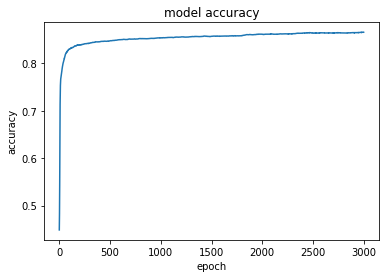

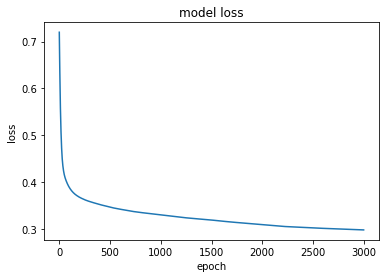

Size: 16932.000000 bits - FPR: 0.593578 



Number of nodes: 45


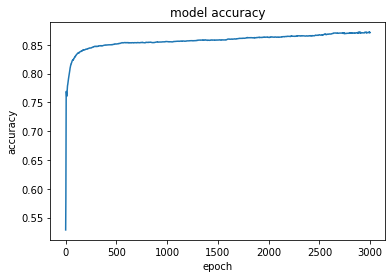

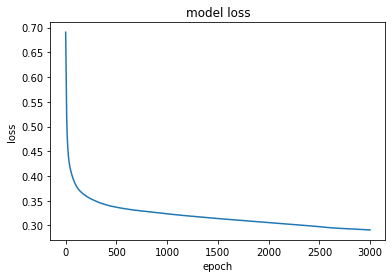

Size: 19044.000000 bits - FPR: 0.545086 



Number of nodes: 50


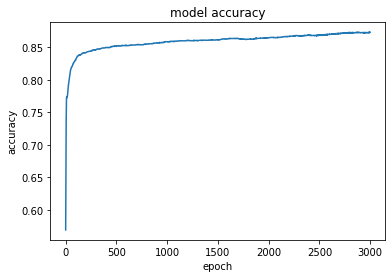

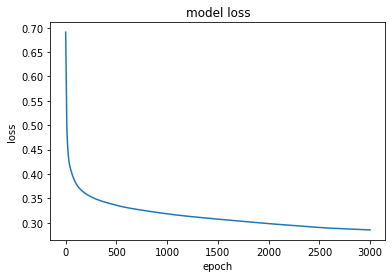

Size: 21156.000000 bits - FPR: 0.524165 



Number of nodes: 55


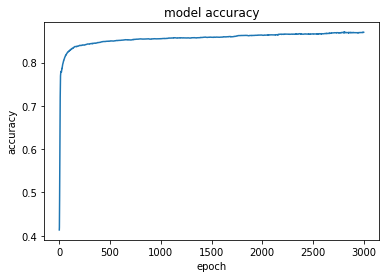

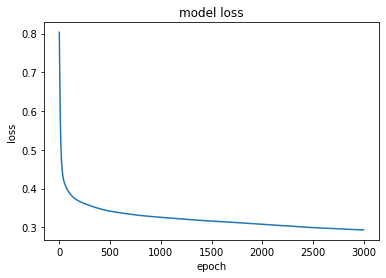

Size: 23268.000000 bits - FPR: 0.492702 



Number of nodes: 60


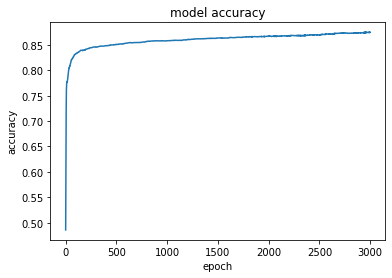

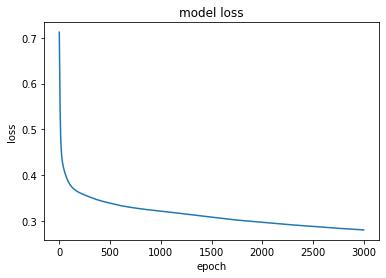

Size: 25380.000000 bits - FPR: 0.455887 



Number of nodes: 65


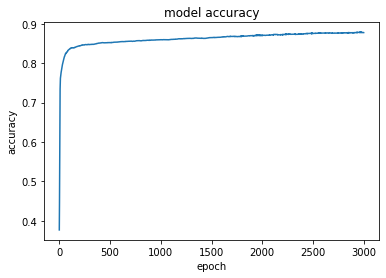

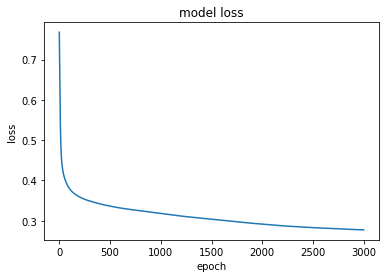

Size: 27492.000000 bits - FPR: 0.423938 



Number of nodes: 70


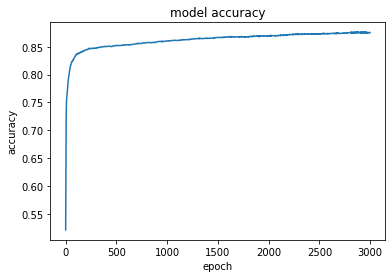

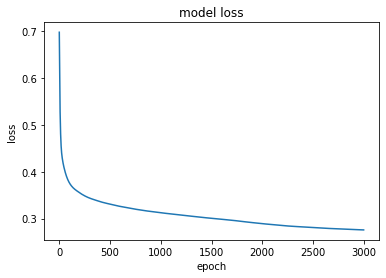

Size: 29604.000000 bits - FPR: 0.419072 



Number of nodes: 75


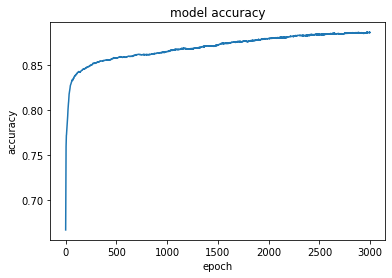

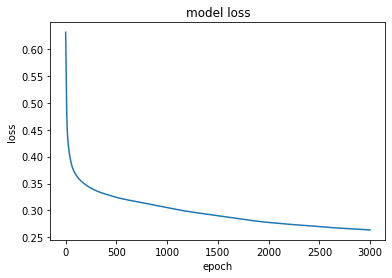

Size: 31716.000000 bits - FPR: 0.371392 



~~~~~~~~ Iteration 3 ~~~~~~~~ 

Number of nodes: 5


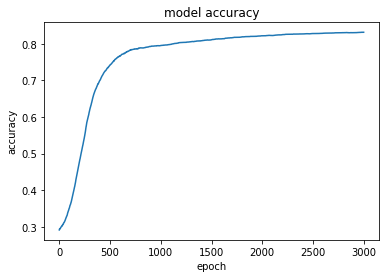

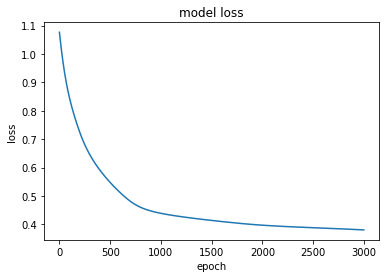

Size: 2148.000000 bits - FPR: 0.986053 



Number of nodes: 10


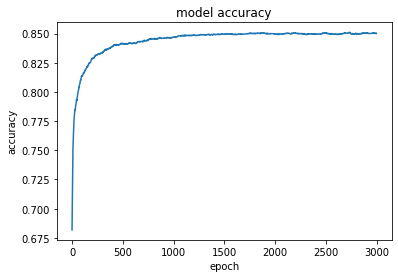

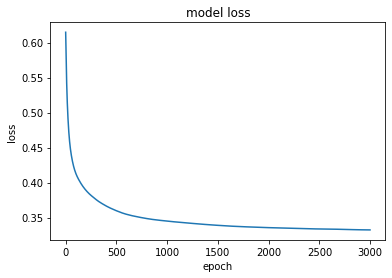

Size: 4260.000000 bits - FPR: 0.905936 



Number of nodes: 15


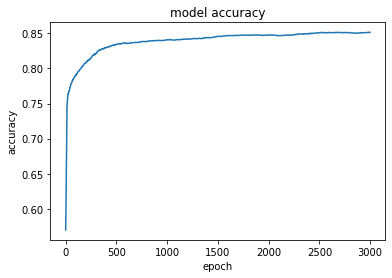

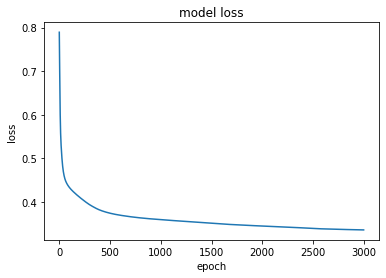

Size: 6372.000000 bits - FPR: 0.853876 



Number of nodes: 20


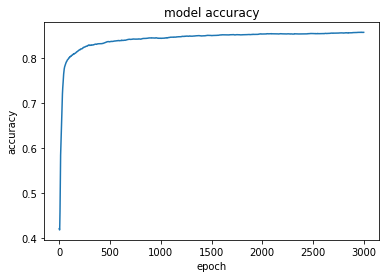

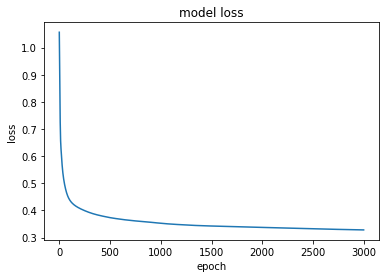

Size: 8484.000000 bits - FPR: 0.831495 



Number of nodes: 25


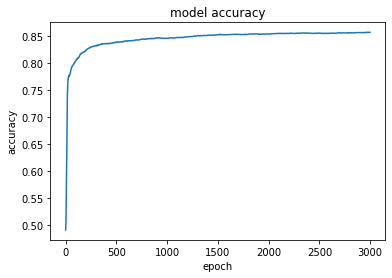

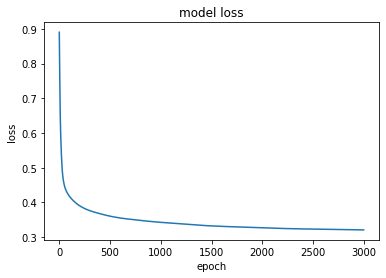

Size: 10596.000000 bits - FPR: 0.760947 



Number of nodes: 30


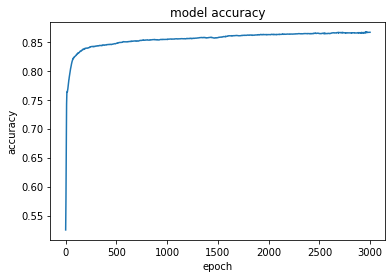

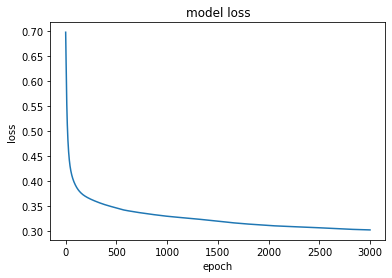

Size: 12708.000000 bits - FPR: 0.704995 



Number of nodes: 35


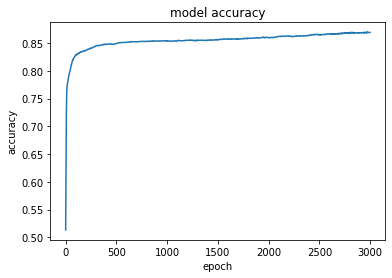

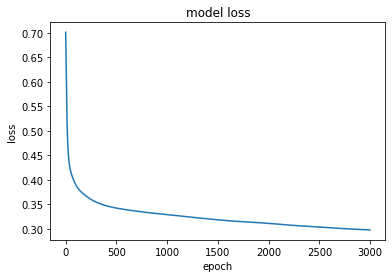

Size: 14820.000000 bits - FPR: 0.618229 



Number of nodes: 40


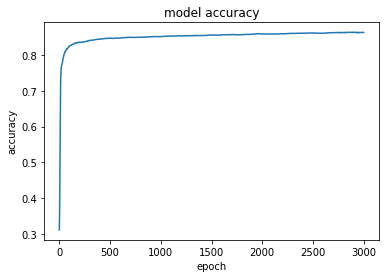

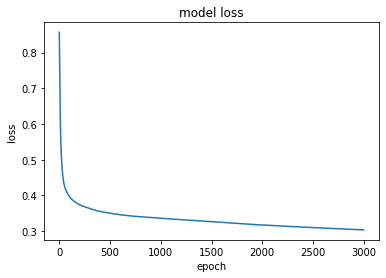

Size: 16932.000000 bits - FPR: 0.598281 



Number of nodes: 45


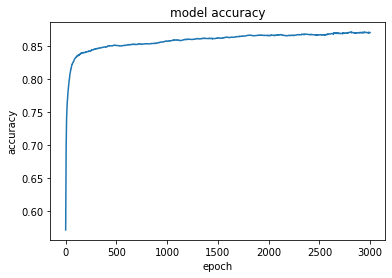

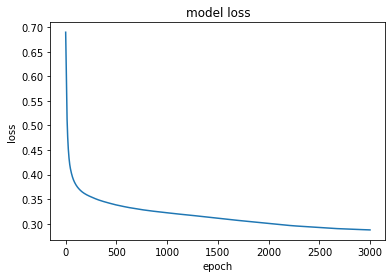

Size: 19044.000000 bits - FPR: 0.546546 



Number of nodes: 50


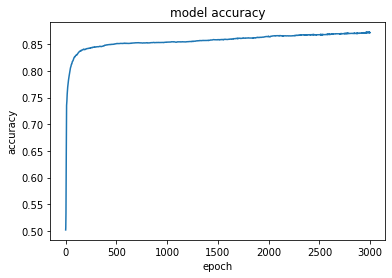

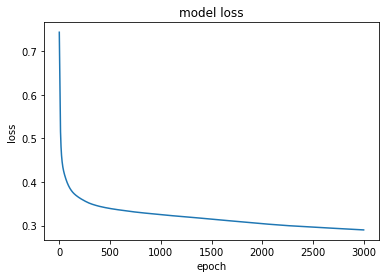

Size: 21156.000000 bits - FPR: 0.530003 



Number of nodes: 55


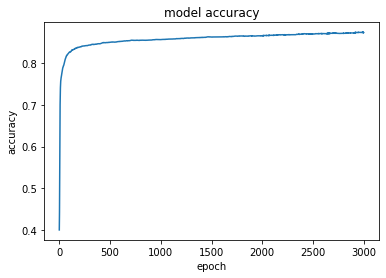

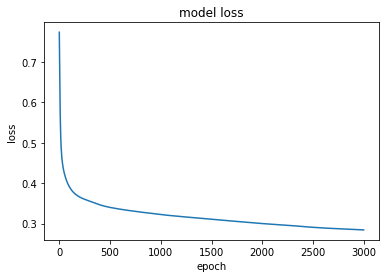

Size: 23268.000000 bits - FPR: 0.466104 



Number of nodes: 60


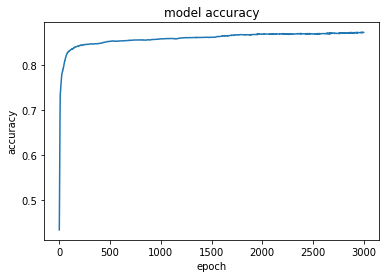

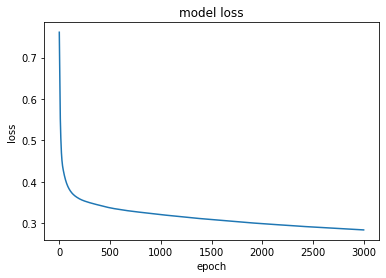

Size: 25380.000000 bits - FPR: 0.451995 



Number of nodes: 65


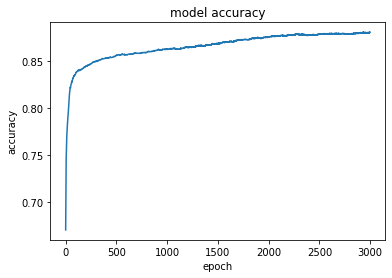

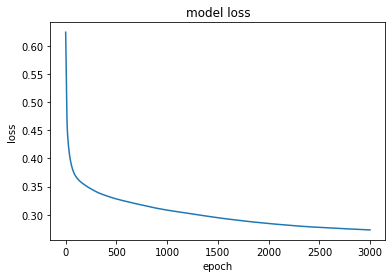

Size: 27492.000000 bits - FPR: 0.424424 



Number of nodes: 70


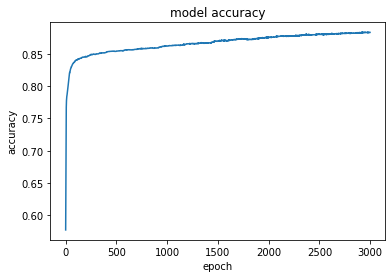

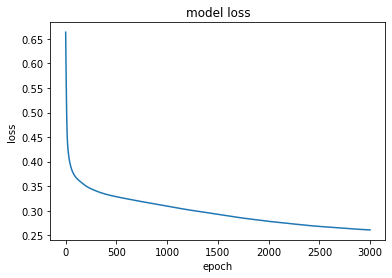

Size: 29604.000000 bits - FPR: 0.379014 



Number of nodes: 75


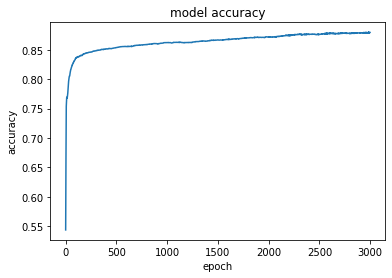

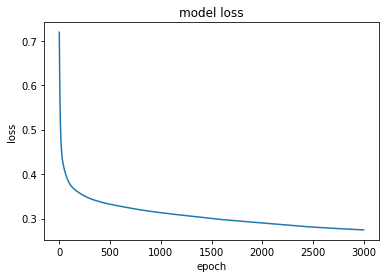

Size: 31716.000000 bits - FPR: 0.377717 





In [15]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values_kraska = []
size_values_kraska = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Kraska(x_train,y_train,x_test,y_test,5,5,15,3000,fpr_values_kraska,size_values_kraska)

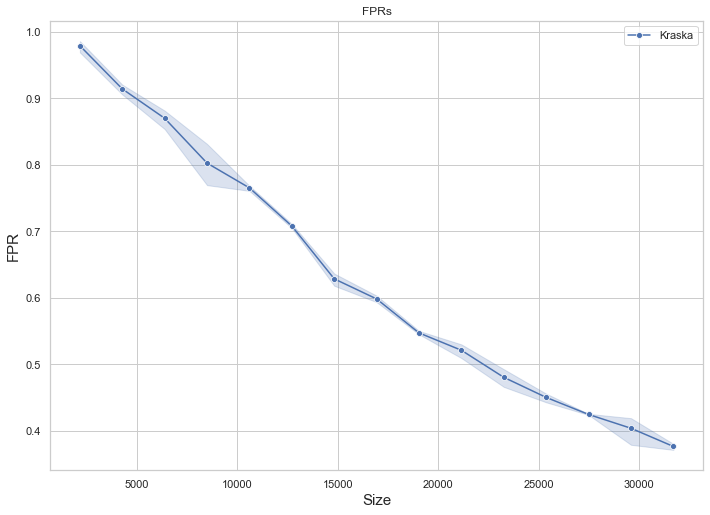

In [16]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values_kraska, y=fpr_values_kraska, err_style="band",label = "Kraska",linewidth = 1.5,marker="o")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Projection model

In [15]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

In [16]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [19]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,800,200,200,100,fpr_values,size_values)

00 Bits - FPR: 0.411126 



Size: 12800 Bits - FPR: 0.402854 



Size: 13000 Bits - FPR: 0.388583 



Size: 13200 Bits - FPR: 0.385339 



Size: 13400 Bits - FPR: 0.370581 



Size: 13600 Bits - FPR: 0.375608 



Size: 13800 Bits - FPR: 0.366202 



Size: 14000 Bits - FPR: 0.360039 



Size: 14200 Bits - FPR: 0.364580 



Size: 14400 Bits - FPR: 0.354849 



Size: 14600 Bits - FPR: 0.331820 



Size: 14800 Bits - FPR: 0.348524 



Size: 15000 Bits - FPR: 0.351768 



Size: 15200 Bits - FPR: 0.347389 



Size: 15400 Bits - FPR: 0.353714 



Size: 15600 Bits - FPR: 0.332631 



Size: 15800 Bits - FPR: 0.340577 



Size: 16000 Bits - FPR: 0.337982 



Size: 16200 Bits - FPR: 0.319818 



Size: 16400 Bits - FPR: 0.324197 



Size: 16600 Bits - FPR: 0.328252 



Size: 16800 Bits - FPR: 0.320467 



Size: 17000 Bits - FPR: 0.326954 



Size: 17200 Bits - FPR: 0.322575 



Size: 17400 Bits - FPR: 0.305547 



Size: 17600 Bits - FPR: 0.334739 



Size: 17800 Bits - FPR: 0.310898 



Size: 1800

# Normal Bloom Filter Values

In [17]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [21]:
print(sum(y_train))
print(len(y_train))

[6688]
12854


In [22]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

600
[6688]


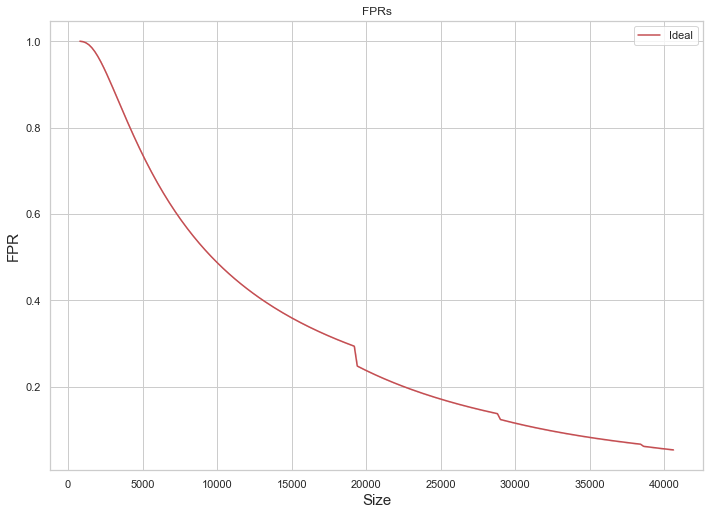

In [23]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# FPR Comparison between Projection Model and Normal Bloom Filter


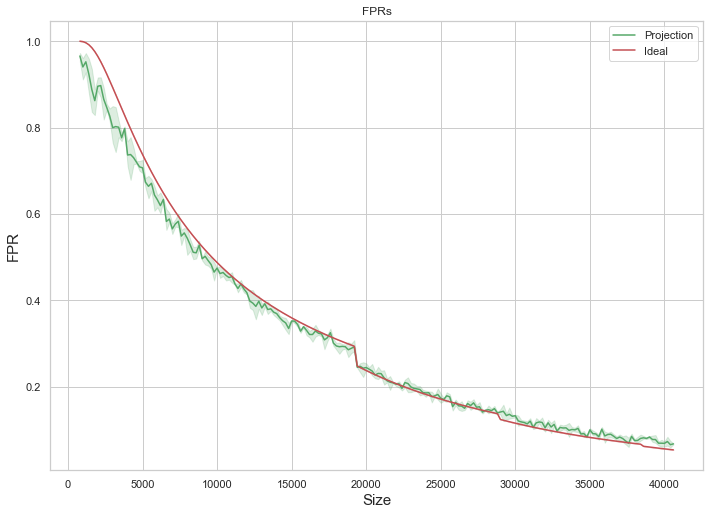

In [24]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

#  FPR Comparison between all 3 models

In [25]:
def get_data_points_Projection2(x_train,x_test,y_train,epochs,fpr_values,size_values_kraska):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in size_values_kraska:
        m = i
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]

In [26]:
# Ran only once instead of thrice as size_values_kraska already has tripple length
fpr_values_projection = []
get_data_points_Projection2(x_train,x_test,y_train,100,fpr_values_projection,size_values_kraska)

(6688, 10)
Size: 2148 Bits - FPR: 0.906098 



Size: 4260 Bits - FPR: 0.759812 



Size: 6372 Bits - FPR: 0.627149 



Size: 8484 Bits - FPR: 0.519948 



Size: 10596 Bits - FPR: 0.418586 



Size: 12708 Bits - FPR: 0.403503 



Size: 14820 Bits - FPR: 0.353552 



Size: 16932 Bits - FPR: 0.324846 



Size: 19044 Bits - FPR: 0.287707 



Size: 21156 Bits - FPR: 0.240837 



Size: 23268 Bits - FPR: 0.204509 



Size: 25380 Bits - FPR: 0.167207 



Size: 27492 Bits - FPR: 0.139475 



Size: 29604 Bits - FPR: 0.134123 



Size: 31716 Bits - FPR: 0.111255 



Size: 2148 Bits - FPR: 0.915342 



Size: 4260 Bits - FPR: 0.717970 



Size: 6372 Bits - FPR: 0.628446 



Size: 8484 Bits - FPR: 0.518164 



Size: 10596 Bits - FPR: 0.438372 



Size: 12708 Bits - FPR: 0.401557 



Size: 14820 Bits - FPR: 0.360039 



Size: 16932 Bits - FPR: 0.303763 



Size: 19044 Bits - FPR: 0.289004 



Size: 21156 Bits - FPR: 0.224619 



Size: 23268 Bits - FPR: 0.203860 



Size: 25380 Bits - FPR: 0.152287 



In [27]:
n = sum(y_train)
y_ideal_k=[]
for x in size_values_kraska:
    y_ideal_k+=[float(ideal_fpr(x,n))]
print(len(y_ideal_k))
print(n)

45
[6688]


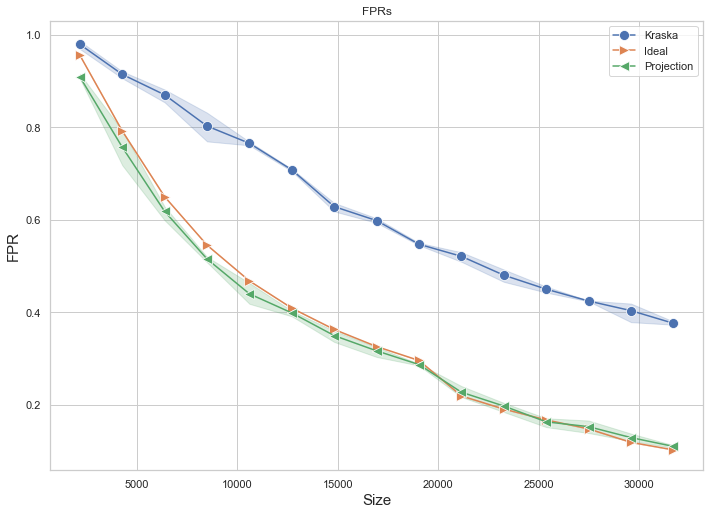

In [28]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values_kraska, y=fpr_values_kraska, err_style="band",marker="o",label = "Kraska",linestyle= "--",markersize=10)
sns.lineplot(x=size_values_kraska, y=y_ideal_k, err_style="band",marker='>',label = "Ideal",linestyle= ":",markersize = 10)
sns.lineplot(x=size_values_kraska, y=fpr_values_projection, err_style="band",marker='<',label = "Projection",linestyle= "-.",markersize = 10)
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Projection Model with only 1 Hash Function


In [29]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = 1  #Setting k as 1
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [48]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,800,200,200,100,fpr_values,size_values)

00 Bits - FPR: 0.413396 



Size: 12800 Bits - FPR: 0.385825 



Size: 13000 Bits - FPR: 0.405449 



Size: 13200 Bits - FPR: 0.367986 



Size: 13400 Bits - FPR: 0.372851 



Size: 13600 Bits - FPR: 0.356147 



Size: 13800 Bits - FPR: 0.384366 



Size: 14000 Bits - FPR: 0.337172 



Size: 14200 Bits - FPR: 0.356309 



Size: 14400 Bits - FPR: 0.344307 



Size: 14600 Bits - FPR: 0.353065 



Size: 14800 Bits - FPR: 0.345605 



Size: 15000 Bits - FPR: 0.369445 



Size: 15200 Bits - FPR: 0.333441 



Size: 15400 Bits - FPR: 0.329387 



Size: 15600 Bits - FPR: 0.315277 



Size: 15800 Bits - FPR: 0.326792 



Size: 16000 Bits - FPR: 0.325819 



Size: 16200 Bits - FPR: 0.329873 



Size: 16400 Bits - FPR: 0.322413 



Size: 16600 Bits - FPR: 0.315440 



Size: 16800 Bits - FPR: 0.309601 



Size: 17000 Bits - FPR: 0.313818 



Size: 17200 Bits - FPR: 0.316575 



Size: 17400 Bits - FPR: 0.325819 



Size: 17600 Bits - FPR: 0.314629 



Size: 17800 Bits - FPR: 0.300357 



Size: 1800

# Comparing new Projection Model with Ideal Bloom Filter

In [49]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

600
[6688]


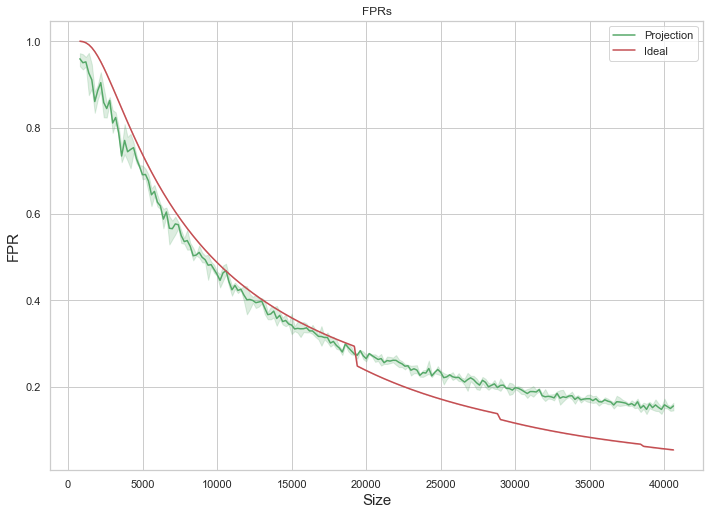

In [50]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Giving independent bitarrays for each hash function in Projection Model

In [34]:
class Projection_Multiple_Array_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1    
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = (size//hash_count) # Size of each bitarray
        self.hash_count = hash_count
        arrays = []
        for i in range(0,hash_count):
            array = bitarray(size//hash_count)
            array.setall(0)
            arrays += [array]
        self.bit_arrays = arrays

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        x = [x]
        hash_values = self.give_hash_values(x)
        for i in range(0,len(hash_values)):
            for j in range(0,self.hash_count):
                self.bit_arrays[j][int(hash_values[i][j])] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in range(0,len(hash_values)):
            for j in range(0,self.hash_count):
                self.bit_arrays[j][int(hash_values[i][j])] = 1
            
    def lookup(self, x):
        x = [x]
        hash_values = self.give_hash_values(x)
        for i in range(0,len(hash_values[0])):
            for j in range(0,self.hash_count):
                if(self.bit_arrays[j][int(hash_values[i][j])] == 0):
                    return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in range(0,len(pos_hash_values)):
        for j in range(0,bf.hash_count):
            if(bf.bit_arrays[j][int(pos_hash_values[i][j])] == 0):
                return -1
    for i in range(0,len(neg_hash_values)):
        flag = 0
        for j in range(0,bf.hash_count):
            if(bf.bit_arrays[j][int(neg_hash_values[i][j])] == 0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in range(0,len(neg_hash_values)):
        flag = 0
        for j in range(0,bf.hash_count):
            if(bf.bit_arrays[j][int(neg_hash_values[i][j])] == 0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

In [35]:
def get_data_points_Projection_Multiple_Array(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_Multiple_Array_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_Multiple_Array_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [40]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection_Multiple_Array(x_train,x_test,y_train,800,200,200,100,fpr_values,size_values)

00 Bits - FPR: 0.367986 



Size: 12800 Bits - FPR: 0.380149 



Size: 13000 Bits - FPR: 0.394908 



Size: 13200 Bits - FPR: 0.376581 



Size: 13400 Bits - FPR: 0.362472 



Size: 13600 Bits - FPR: 0.383231 



Size: 13800 Bits - FPR: 0.368959 



Size: 14000 Bits - FPR: 0.365066 



Size: 14200 Bits - FPR: 0.380798 



Size: 14400 Bits - FPR: 0.367013 



Size: 14600 Bits - FPR: 0.360201 



Size: 14800 Bits - FPR: 0.366688 



Size: 15000 Bits - FPR: 0.331657 



Size: 15200 Bits - FPR: 0.356633 



Size: 15400 Bits - FPR: 0.342037 



Size: 15600 Bits - FPR: 0.330684 



Size: 15800 Bits - FPR: 0.341713 



Size: 16000 Bits - FPR: 0.339929 



Size: 16200 Bits - FPR: 0.348200 



Size: 16400 Bits - FPR: 0.331009 



Size: 16600 Bits - FPR: 0.315602 



Size: 16800 Bits - FPR: 0.328414 



Size: 17000 Bits - FPR: 0.305384 



Size: 17200 Bits - FPR: 0.321440 



Size: 17400 Bits - FPR: 0.300681 



Size: 17600 Bits - FPR: 0.309439 



Size: 17800 Bits - FPR: 0.295491 



Size: 1800

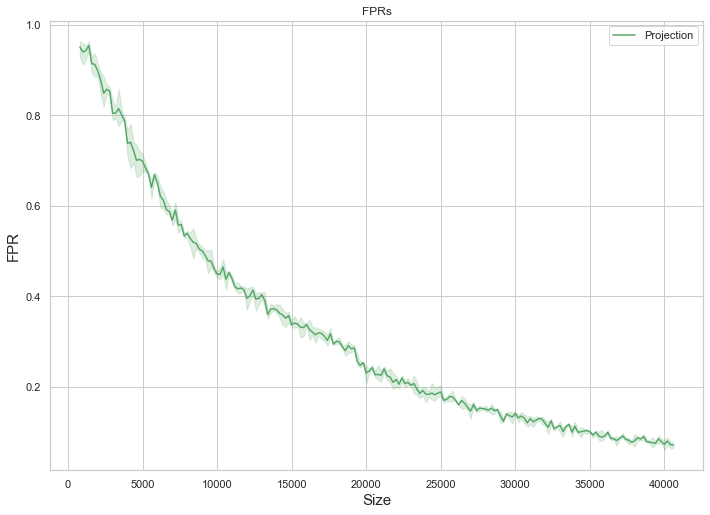

In [41]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [42]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

600
[6688]


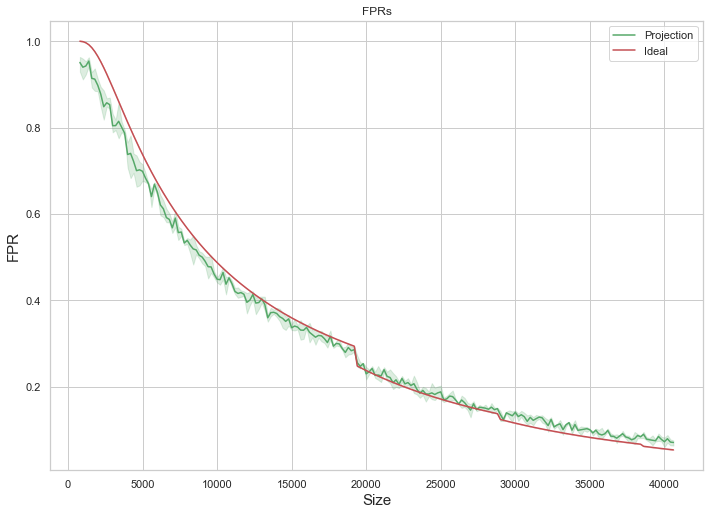

In [43]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Kernel with Polynomial

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,5,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        self.unit_vectors = vectors #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        self.scaler = MinMaxScaler()

    def give_hash_values(self,X):
        projections = self.kernel_pol(X,0.1)
        norm_proj = self.scaler.transform(projections) ### Transforming data with new min-max values
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint
        
    def bulk_add(self, X):
        projections = self.kernel_pol(X,0.1)
        norm_proj = self.scaler.fit_transform(projections)
        hash_values = (norm_proj*(self.size-1)).astype(int)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(i<0 or i>=self.size or self.bit_array[i]==0): ### Make sure transform doesn't cause index to go out of range
                return False
        return True
    def kernel_pol(self,X,gamma):
        projections = np.zeros((X.shape[0],self.unit_vectors.shape[0]))
        for i in range(0,X.shape[0]):
            for j in range(0,self.unit_vectors.shape[0]):
                val=(gamma*np.dot(X[i],self.unit_vectors[j]))
                projections[i,j]=val
        return projections
    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(j<0 or j>=bf.size or bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(j<0 or j>=bf.size or bf.bit_array[j]==0): ### Check for out of range
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(j<0 or j>=bf.size or bf.bit_array[j]==0):  ### Check for out of range
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [23]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        #k = eff_k(m,n,1)
        k=1
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            #print(bf.bit_array)
            temp = find_fpr(bf,x_pos,x_neg)
            #print(temp,"fpr on train set")
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [24]:
num_of_iterations = 1 #Increase to make graph smoother

fpr_values_poly = []
size_values_poly = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,800,400,100,100,fpr_values_poly,size_values_poly)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(6688, 10)
Size: 800 Bits - FPR: 0.985890 



Size: 1200 Bits - FPR: 0.947454 



Size: 1600 Bits - FPR: 0.937399 



Size: 2000 Bits - FPR: 0.943237 



Size: 2400 Bits - FPR: 0.845118 



Size: 2800 Bits - FPR: 0.893934 



Size: 3200 Bits - FPR: 0.860850 



Size: 3600 Bits - FPR: 0.860363 



Size: 4000 Bits - FPR: 0.820143 



Size: 4400 Bits - FPR: 0.820629 



Size: 4800 Bits - FPR: 0.752838 



Size: 5200 Bits - FPR: 0.791275 



Size: 5600 Bits - FPR: 0.813007 



Size: 6000 Bits - FPR: 0.708887 



Size: 6400 Bits - FPR: 0.742945 



Size: 6800 Bits - FPR: 0.747324 



Size: 7200 Bits - FPR: 0.752676 



Size: 7600 Bits - FPR: 0.722673 



Size: 8000 Bits - FPR: 0.662828 



Size: 8400 Bits - FPR: 0.636231 



Size: 8800 Bits - FPR: 0.688777 



Size: 9200 Bits - FPR: 0.603795 



Size: 9600 Bits - FPR: 0.612553 



Size: 10000 Bits - FPR: 0.638501 



Size: 10400 Bits - FPR: 0.640448 



Size: 10800 Bits - FPR: 0.550762 



Size: 11200 Bits - 

In [25]:
n = sum(y_train)
y_ideal_k=[]
for x in size_values_poly:
    y_ideal_k+=[float(ideal_fpr(x,n))]
print(len(y_ideal_k))
print(n)


100
[6688]


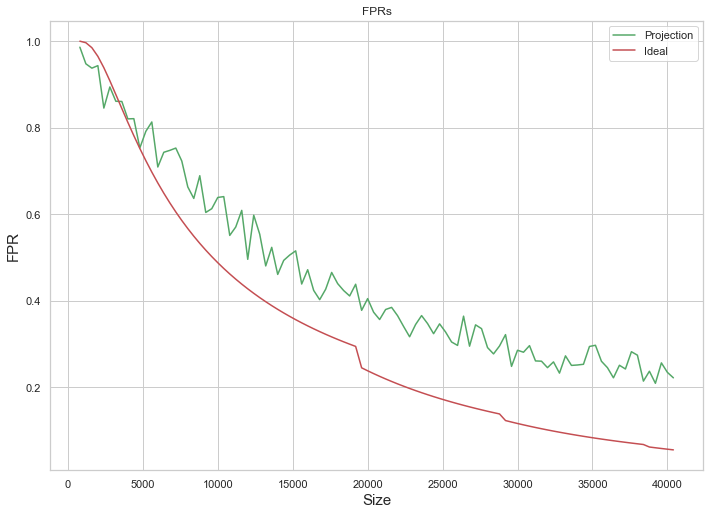

In [26]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values_poly, y=fpr_values_poly, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values_poly, y=y_ideal_k, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [27]:
saved_data = list(zip(size_values_poly, fpr_values_poly, y_ideal_k))
df = pd.DataFrame(saved_data,columns = ['Size', 'Projection_PolyKernel0.5 FPR', 'Ideal FPR'])
df.head()

Size  Projection_PolyKernel0.5 FPR  Ideal FPR
0   800                      0.985890   0.999767
1  1200                      0.947454   0.996211
2  1600                      0.937399   0.984721
3  2000                      0.943237   0.964734
4  2400                      0.845118   0.938409

In [28]:
df.to_csv('E:\SURA Data\Magic_kernelpolynomia_proj_sd_5.csv')